In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

Data cleaning 

In [2]:
df = pd.read_csv("./data/final_data.zip") #/!\ à changer, c'est juste les anciennes données
print(df.shape)
print(df.head(10))
df = df.dropna()
print(df.shape)
df["CVSS"] = pd.to_numeric(df["CVSS"])
df["EPSS"] = pd.to_numeric(df["EPSS"])
#df["Longueur description"] = pd.to_numeric(df["Longueur description"])

/var/folders/8s/dc7b8qvs1rs11dp05g8_n5xw0000gp/T/ipykernel_20196/1122447631.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/final_data.zip") #/!\ à changer, c'est juste les anciennes données


(225314, 16)
               ID_ANSSI                                              Titre  \
0  CERTFR-2024-AVI-0465                 Vulnérabilité dans MongoDB PyMongo   
1  CERTFR-2024-AVI-0936  Multiples vulnérabilités dans les produits Splunk   
2  CERTFR-2024-AVI-0936  Multiples vulnérabilités dans les produits Splunk   
3  CERTFR-2024-AVI-0936  Multiples vulnérabilités dans les produits Splunk   
4  CERTFR-2024-AVI-0936  Multiples vulnérabilités dans les produits Splunk   
5  CERTFR-2024-AVI-0873     Multiples vulnérabilités dans les produits IBM   
6  CERTFR-2024-AVI-0873     Multiples vulnérabilités dans les produits IBM   
7  CERTFR-2024-AVI-0873     Multiples vulnérabilités dans les produits IBM   
8  CERTFR-2024-AVI-0873     Multiples vulnérabilités dans les produits IBM   
9  CERTFR-2024-AVI-0873     Multiples vulnérabilités dans les produits IBM   

   Type                        Date             CVE  CVSS Base Severity  \
0  Avis  2024-06-06T00:00:00.000000   CVE-2024-5629  

Label encoding

In [3]:
le = LabelEncoder()
df["Severity_encoded"] = le.fit_transform(df["Base Severity"])

Random Forest pour prédire Base Severity

In [4]:
X = df[["CVSS", "EPSS"]]
y = df["Severity_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluation 

In [5]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Critique       1.00      1.00      1.00      1394
      Faible       1.00      1.00      1.00       987
     Moyenne       1.00      1.00      1.00     12019
      Élevée       1.00      1.00      1.00     18411

    accuracy                           1.00     32811
   macro avg       1.00      1.00      1.00     32811
weighted avg       1.00      1.00      1.00     32811

[[ 1394     0     0     0]
 [    0   987     0     0]
 [    0     0 12019     0]
 [    0     0     0 18411]]


Visualization

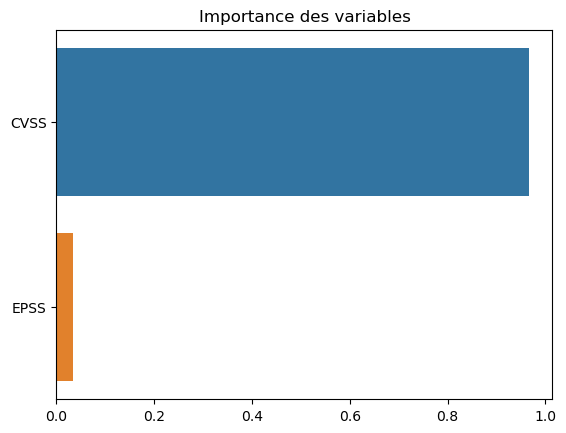

In [6]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Importance des variables")
plt.show()

Random Forest pour prédire EPSS

In [7]:
df_reg = df.copy()

df_reg = df_reg.dropna(subset=["EPSS", "CVSS"])

df_reg["EPSS"] = pd.to_numeric(df_reg["EPSS"], errors="coerce")
df_reg["CVSS"] = pd.to_numeric(df_reg["CVSS"], errors="coerce")
#df_reg["Longueur description"] = pd.to_numeric(df_reg["Longueur description"], errors="coerce")

for col in ["Base Severity", "CWE"]:
    df_reg[col] = LabelEncoder().fit_transform(df_reg[col].astype(str))


features = ["CVSS", "Base Severity", "CWE"]
X = df_reg[features]
y = df_reg["EPSS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))

MAE : 0.02567866325278999
MSE : 0.007862145444514424
RMSE: 0.08866873995109226
R²  : 0.32531238228870807


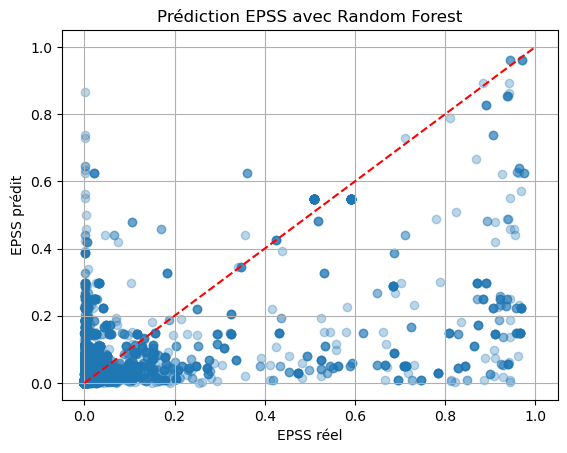

In [10]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("EPSS réel")
plt.ylabel("EPSS prédit")
plt.title("Prédiction EPSS avec Random Forest")
plt.plot([0, 1], [0, 1], 'r--')
plt.grid()
plt.show()

XGBoost Regressor pour prédire EPSS

In [11]:

for col in ["Base Severity", "CWE"]:
    df[col] = df[col].astype(str)  
    df[col] = LabelEncoder().fit_transform(df[col])
# Même préparation que pour RandomForest
features = ["CVSS", "Base Severity", "CWE"]
X = df[features]
y = df["EPSS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))

MAE : 0.028884145514037608
RMSE: 0.09229784948213943
R²  : 0.2689537891269437


Random Forest est mieux que XGBoost

Random Forest pour prédire le nom de l'éditeur

Random Forest sans SMOTE (échantillonage)

In [12]:
df_clf = df.dropna(subset=["Éditeur", "CVSS", "EPSS", "Base Severity"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  # éditeurs fréquents

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_severity = LabelEncoder()
df_clf["Base Severity"] = le_severity.fit_transform(df_clf["Base Severity"])

le_cwe = LabelEncoder()
df_clf["CWE"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))


X = df_clf[["CVSS", "EPSS", "Base Severity", "CWE"]]
y = df_clf["Éditeur_encoded"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

                                  precision    recall  f1-score   support

                             AMD       0.96      0.97      0.96       133
                           Adobe       0.83      0.44      0.57        98
      Apache Software Foundation       0.89      0.90      0.89        86
                           Apple       0.85      0.85      0.85       551
                         Arm Ltd       1.00      0.30      0.46        10
          Axis Communications AB       0.83      0.59      0.69        17
                         CODESYS       1.00      0.98      0.99       110
                           Cisco       0.73      0.57      0.64       104
              ESET, spol. s r.o.       0.92      1.00      0.96        12
              Eclipse Foundation       1.00      1.00      1.00        16
                         Elastic       0.60      0.14      0.22        22
                              F5       0.61      0.43      0.51        46
                        Fortinet     

Random Forest avec SMOTE

In [13]:

from imblearn.over_sampling import SMOTE

df_clf = df.dropna(subset=["Éditeur", "CVSS", "EPSS", "Base Severity"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_severity = LabelEncoder()
df_clf["Base Severity"] = le_severity.fit_transform(df_clf["Base Severity"])

le_cwe = LabelEncoder()
df_clf["CWE"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))


X = df_clf[["CVSS", "EPSS", "Base Severity", "CWE"]]
y = df_clf["Éditeur_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

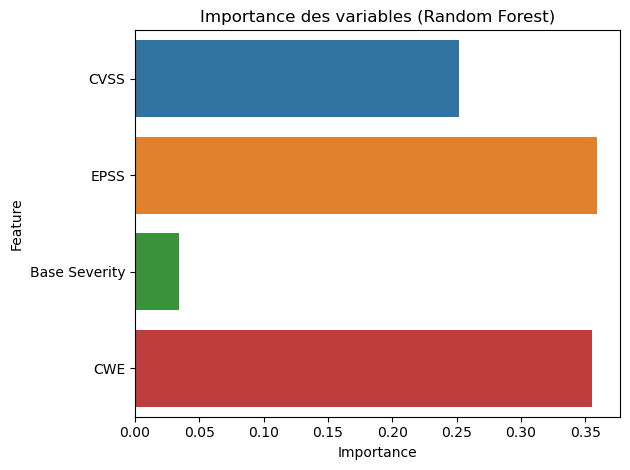

In [ ]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importance des variables (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

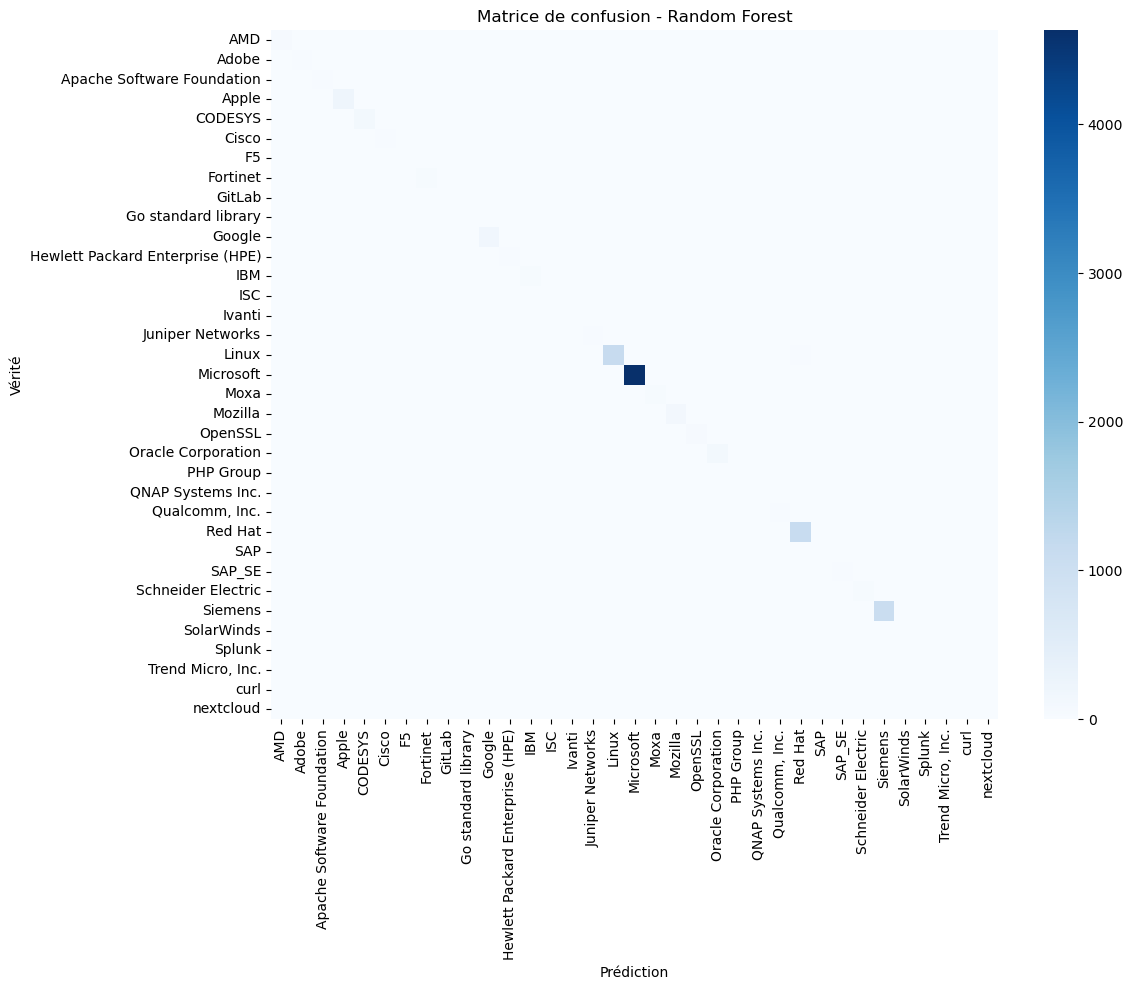

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_, 
            annot=False, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


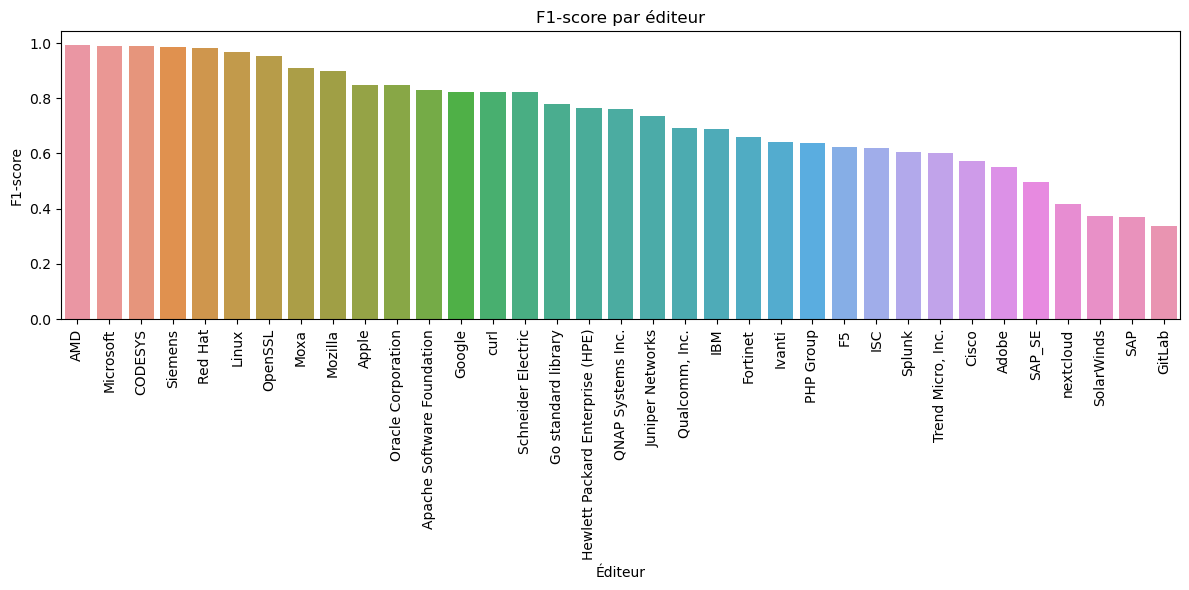

In [ ]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        f1_scores[label] = report_dict[str(i)]["f1-score"]
    except KeyError:
        f1_scores[label] = 0


f1_scores_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores_sorted.keys()), y=list(f1_scores_sorted.values()))
plt.xticks(rotation=90)
plt.title("F1-score par éditeur")
plt.ylabel("F1-score")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


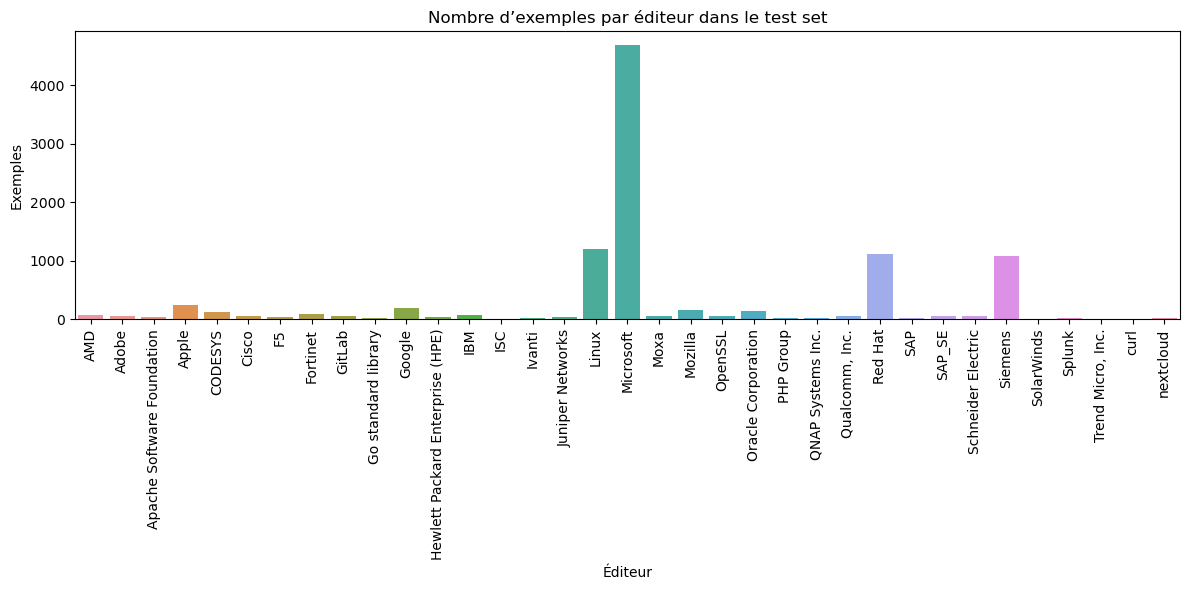

In [ ]:
support = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        support[label] = report_dict[str(i)]["support"]
    except KeyError:
        support[label] = 0  


plt.figure(figsize=(12, 6))
sns.barplot(x=list(support.keys()), y=list(support.values()))
plt.xticks(rotation=90)
plt.title("Nombre d’exemples par éditeur dans le test set")
plt.ylabel("Exemples")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()